In [60]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2

from matplotlib import pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

from helper_functions import *




In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
train_data = torchvision.datasets.CIFAR10(root='./data',
                                          download=True,
                                          transform=v2.Compose(
                                              [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                          train=True,
                                          target_transform=None
                                          )

test_data = torchvision.datasets.CIFAR10(root='./data',
                                          download=True,
                                          transform=v2.Compose(
                                              [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                          train=False,
                                          target_transform=None
                                          )



Files already downloaded and verified
Files already downloaded and verified


In [63]:
train_data
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

In [64]:
image, label = train_data[10000]

image, label


image.shape

torch.Size([3, 32, 32])

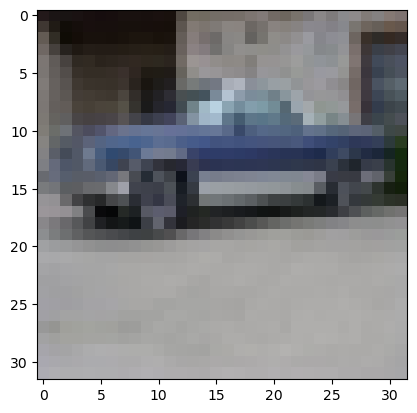

In [65]:
img = plt.imshow(image.permute(1,2,0).numpy())

In [66]:
classes = train_data.class_to_idx
classes

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

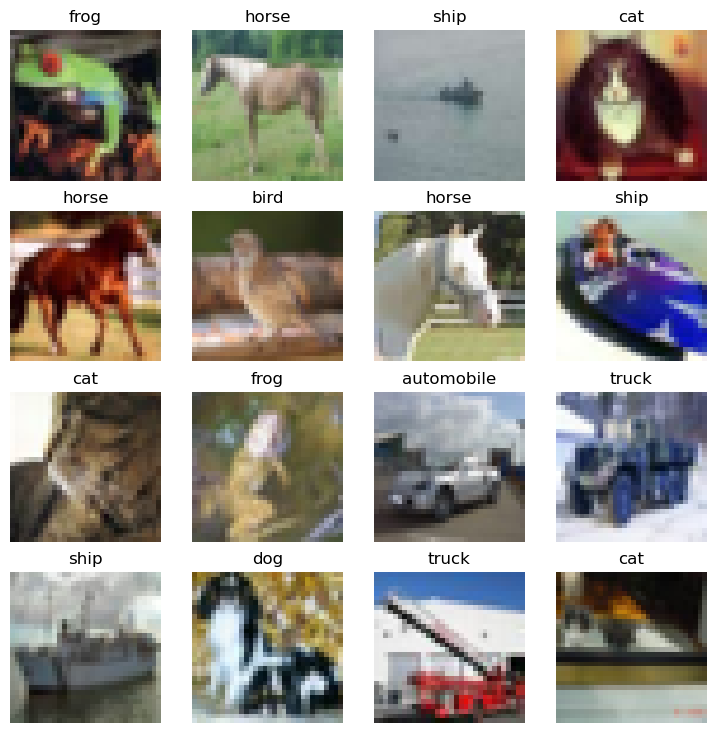

In [67]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9), facecolor='white')

rows, cols = 4, 4

for i in range(16):
    random_idx = torch.randint(0, len(train_data), size=(1,)).item()
    # print(random_idx)
    image = train_data[random_idx][0]
    label = train_data[random_idx][1]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1,2,0).numpy())
    key = next((k for k, v in classes.items() if v == label), None)
    plt.title(key)
    plt.axis('off')

# Getting DataLoader Ready

In [68]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [69]:
len(train_dataloader)

782

In [70]:
class Cifer10model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Cifer10model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=num_classes),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_0 = Cifer10model(input_size=3, hidden_size=32, num_classes=10).to(device)
model_0

Cifer10model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [71]:
rand_image = torch.randn(1, 3, 32, 32).to(device)
model_0(rand_image)

tensor([[ 0.0368,  0.0235, -0.0250,  0.0352,  0.0027,  0.0482,  0.0124, -0.0164,
          0.0350, -0.0025]], grad_fn=<AddmmBackward0>)

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

In [73]:
epochs = 6
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        model_0.train()

        y_preds = model_0(x)

        loss = loss_fn(y_preds, y)
        train_loss += loss

        acc = accuracy_fn(y_pred=y_preds.argmax(dim=1), y_true=y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} Samples")

    train_loss /= len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    with torch.inference_mode():
        test_loss, test_acc = 0, 0

        for batch, (x, y) in enumerate(test_dataloader):
            test_preds = model_0(x)

            test_loss += loss_fn(test_preds, y)

            test_acc += accuracy_fn(y_pred=test_preds.argmax(dim=1), y_true=y)

        test_loss /= len(test_dataloader)

        test_acc = test_acc / len(test_dataloader)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")




  0%|          | 0/6 [00:00<?, ?it/s]

Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 1.5991615056991577 | Train Acc: 42.47522378516624 | Test Loss: 1.296897530555725 | Test Acc: 53.48328025477707
Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 1.209139108657837 | Train Acc: 57.16512148337596 | Test Loss: 1.1024938821792603 | Test Acc: 61.255971337579616
Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 1.0243518352508545 | Train Acc: 64.26430626598466 | Test Loss: 0.9939996004104614 | Test Acc: 65.18710191082802
Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 0.9119815230369568 | Train Acc: 68.16256393861893 | Test Loss: 0.9190850853919983 | Test Acc: 67.87420382165605
Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 0.8320485949516296 | Train Acc: 71.0497921994885 | Test Loss: 0.8957894444465637 | Test Acc: 68.72014331210191
Looked at 0/50000 Samples
Looked at 25600/50000 Samples
Train Loss: 0.7836520671844482 | Train Acc: 72

In [74]:
# torch.save(model_0.state_dict(), "cifar10_model_state.pth")
#

In [75]:
# Recreate the model instance (make sure it matches the saved model)
# model = Cifer10model(input_size=3, hidden_size=64, num_classes=10)
#
# # Load the saved state dict into the model
# model.load_state_dict(torch.load("cifar10_model_state.pth"))
#
# # Set model to evaluation mode
# model.eval()
